Punto 1

In [3]:
import os
import pandas as pd
from scipy import stats
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
#llamar datos de la carpeta data; dirBase, ciudad &origenData =Str 

def llamarDatos(ciudad, origenData):
    serie=os.path.join('.','data',ciudad,origenData+'.csv')
    serie_pd = pd.read_csv(serie, sep = ';',encoding='latin-1')
    return serie_pd

ciudades: Barranquilla, Cali,
          Carmendebolivar, Medellin,
          SantaMarta, Sucre, Uribia, Valledupar
          
origenesData: IDEAM, NREL

In [5]:
#Calcular la energía total al mes
def ghiMensual(serie):
    agnos=sorted (serie['AÑO'].unique()) #sorted() organiza los datos de menor a mayot
    nombre_energia = list(serie)[-1] #list [x](i) toma el primer valor de la columna i del dataFrame X
    DefinitiveDataFrame =pd.DataFrame(columns=["AÑO","MES","DIAS","GHIMensual","GHIdiarioPromedio"+nombre_energia]) #Construyo el nuevo DataFrame
    for agno in agnos:
        for mes in range (1,13): #range() no toma el último valor
            dias=sorted(serie[(serie['AÑO']==agno)&(serie['MES']==mes)]['DIA'].unique()) #tomo el número de dias por mes
            ghiMensual=serie.loc[((serie['AÑO']==agno)&(serie['MES']==mes)),nombre_energia].sum()/1000 #calculo la suma de la energia mensual en kWh
            #serie.loc[cond,'x'] me toma los valores de la columna 'x' de un dataframe dada una condicion
            ghiDiario=ghiMensual/dias[-1] #Calculo del valor diario promedio mensual            
            ghi=dict([("AÑO",agno),("MES",mes),("DIAS",dias[-1]),("GHIMensual",ghiMensual),("GHIdiarioPromedio"+nombre_energia,ghiDiario)]) #retorna una lista: {Mes:x,DIAS:y,etc}
            DefinitiveDataFrame=DefinitiveDataFrame.append(ghi, ignore_index=True) #Guardo mis datos en el DataFrame ignore_index ignora los labels de los datos
    return DefinitiveDataFrame

In [6]:
def enficc(serie):
    percentil=0.01
    en= ghiMensual(serie).quantile(q=percentil,numeric_only=True)["GHIdiarioPromedio"+list(serie)[-1]]
    return 'La ENFICC 99% es: ',en

In [7]:
serie=llamarDatos("Barranquilla","IDEAM")
enficc(serie)

('La ENFICC 99% es: ', 4.1605902581736194)

Punto Número 2

In [8]:
def graficar(ciudad1,ciudad2,ciudad3,origenData):
    serie1=llamarDatos(ciudad1,origenData)
    serie2=llamarDatos(ciudad2,origenData)
    serie3=llamarDatos(ciudad3,origenData)
    data1=sorted(ghiMensual(serie1)["GHIdiarioPromedio"+list(serie1)[-1]])
    data2=sorted(ghiMensual(serie2)["GHIdiarioPromedio"+list(serie2)[-1]])
    data3=sorted(ghiMensual(serie3)["GHIdiarioPromedio"+list(serie3)[-1]])
    numdatos1=range(len(data1))
    numdatos2=range(len(data2))
    numdatos3=range(len(data3))
    fig=figure()
    pylab.xlabel("Datos")
    pylab.ylabel("Energía/Energía Base")
    pylab.title(origenData)
    pylab.plot(numdatos1,data1/data1[0],'-k', label=ciudad1)
    pylab.plot(numdatos2,data2/data2[0],'-y', label=ciudad2)
    pylab.plot(numdatos3,data3/data3[0],'-r', label=ciudad3)
    pylab.legend(loc='upper left')
    return



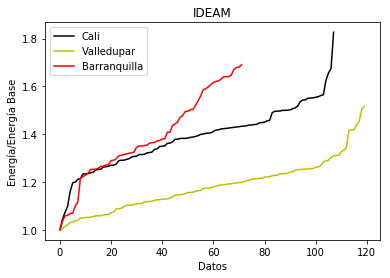

In [9]:
graficar("Cali","Valledupar","Barranquilla","IDEAM")

Punto 3

In [10]:
#OJO, datos satelitales son NREL, datos reales son IDEAM
#Seleccionar pedazos de series

#serieObj tiene como entrada el año inicial, el mes inicial, el año final, el mes final y la ciudad del trozo de la serie de datos medidos NREL con lo cuales se corregirá
#Su salida es un DataFrame conteniendo el trozo de datos medidos en sitio "NREL" a corregir
def serieObj (agnoInicial,mesInicial,agnoFinal,mesFinal,ciudad):
    origen='IDEAM'
    x=llamarDatos(ciudad,origen)[(llamarDatos(ciudad,origen)['AÑO']>=agnoInicial)&
                               (llamarDatos(ciudad,origen)['MES']>=mesInicial)&
                               (llamarDatos(ciudad,origen)['AÑO']<=agnoFinal)&
                               (llamarDatos(ciudad,origen)['MES']<=mesFinal)]
    return x
#serieRef tiene como entrada el año inicial, el mes inicial, el año final, el mes final y la ciudad del trozo de la serie de datos medidos NREL con lo cuales se corregirá
#Su salida es un DataFrame conteniendo el trozo de datos satelitales "IDEAM" en la misma temporalidad que el trozo de NREL con lo cuales se corregirá
def serieRef (agnoInicial,mesInicial,agnoFinal,mesFinal,ciudad):
    origen='NREL'
    y=llamarDatos(ciudad,origen)[(llamarDatos(ciudad,origen)['AÑO']>=agnoInicial)&
                               (llamarDatos(ciudad,origen)['MES']>=mesInicial)&
                               (llamarDatos(ciudad,origen)['AÑO']<=agnoFinal)&
                               (llamarDatos(ciudad,origen)['MES']<=mesFinal)]
    return y
#MCP tiene como entrada el año inicial, el mes inicial, el año final, el mes final y la ciudad del trozo de la serie de datos medidos NREL con lo cuales se corregirá
#Su salida es un dataframe con Año, Mes, Dia, Datos satelitales "IDEAM" y Datos corregidos "MCP" en temporalidad horaria de 10 años
def MCP (agnoInicial,mesInicial,agnoFinal,mesFinal,ciudad):
    #Parámetros para calcular MCP
    origenRef='NREL'
    origenObj='IDEAM'
    Ref=serieRef (agnoInicial,mesInicial,agnoFinal,mesFinal,ciudad)[origenRef]
    Obj=serieObj (agnoInicial,mesInicial,agnoFinal,mesFinal,ciudad)[origenObj]
    GHImean_Ref=Ref.sum()/count_nonzero(Ref)
    GHImean_Obj=Obj.sum()/count_nonzero(Obj)
    DSTD_Ref=Ref[Ref!=0].std()
    DSTD_Obj=Obj[Obj!=0].std()
    relDSTDs=DSTD_Obj/DSTD_Ref
    #corrección
    refLarga=llamarDatos(ciudad,origenRef)[origenRef]
    A=GHImean_Obj-(relDSTDs*GHImean_Ref)
    B=relDSTDs*refLarga
    df=llamarDatos(ciudad,origenRef)
    df['IDEAM']=llamarDatos(ciudad,origenObj)[origenObj]
    df['MCP']=A+B
    return df
#plotPorCiudad tiene como entrada el año inicial, el mes inicial, el año final, el mes final y la ciudad del trozo de la serie de datos medidos NREL con lo cuales se corregirá
#Su salida es una gráfica con los promedios mensuales en temporalidad mensual de 10 años
def plotPorCiudad (agnoInicial,mesInicial,agnoFinal,mesFinal,ciudad):
    origenRef='NREL'
    origenMed='IDEAM'
    Corregida=ghiMensual(MCP(agnoInicial,mesInicial,agnoFinal,mesFinal,ciudad))['GHIMensual']
    Satelitales=ghiMensual(llamarDatos(ciudad,origenRef))['GHIMensual']
    x=range(len(Corregida))
    fig=figure()
    pylab.xlabel('Meses')
    pylab.ylabel(r'$GHI[\frac{W}{m^2}]$')
    pylab.plot(x,Satelitales,'-k', label='Datos Satelitales')
    pylab.plot(x,Corregida,'-r', label='Datos Corregidos')
    pylab.legend(loc='upper left')
    return 'CUIDADO: La serie de datos medidos inicia en el año ',serieObj (agnoInicial,mesInicial,agnoFinal,mesFinal,ciudad)['AÑO'].min() 

('CUIDADO: La serie de datos medidos inicia en el año ', 2010)

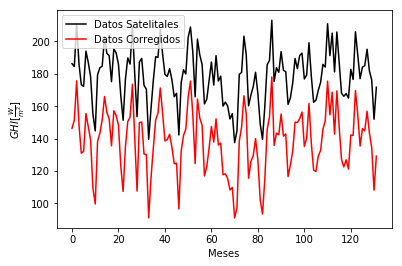

In [11]:
plotPorCiudad(2010,1,2015,1,"Barranquilla")

Punto 4

In [29]:
#Cortar Serie
def cortarSerie(serie,agnoInicial,agnoFinal):
    x=serie[(serie['AÑO']>=agnoInicial)&
            (serie['AÑO']<=agnoFinal)]
    return x
#Error RMS
def RMS(agnoInicial,mesInicial,agnoFinal,mesFinal,ciudad):
    modMCP='MCP'
    modNREL='NREL'
    obs='IDEAM'
    #
    XmodMCP=MCP(agnoInicial,mesInicial,agnoFinal,mesFinal,ciudad)[modMCP]
    XmodNREL=MCP(agnoInicial,mesInicial,agnoFinal,mesFinal,ciudad)[modNREL]
    Xobs=MCP(agnoInicial,mesInicial,agnoFinal,mesFinal,ciudad)[obs]
    #       
    RMSMCPinsideSum=(Xobs-XmodMCP)**2
    RMSNRELinsideSum=(Xobs-XmodNREL)**2
    #
    RMSMCP=((RMSMCPinsideSum.sum()/len(RMSMCPinsideSum))**0.5)/(Xobs.max()-Xobs.min())
    RMSNREL=((RMSNRELinsideSum.sum()/len(RMSNRELinsideSum))**0.5)/(Xobs.max()-Xobs.min())
    #
    df=pd.DataFrame({'RMS':[0,RMSNREL,RMSMCP]},index=['ideal','NREL vs IDEAM','MCP vs IDEAM'])
    return df
def MBE(agnoInicial,mesInicial,agnoFinal,mesFinal,ciudad):
    modMCP='MCP'
    modNREL='NREL'
    obs='IDEAM'
    #
    XmodMCP=MCP(agnoInicial,mesInicial,agnoFinal,mesFinal,ciudad)[modMCP]
    XmodNREL=MCP(agnoInicial,mesInicial,agnoFinal,mesFinal,ciudad)[modNREL]
    Xobs=MCP(agnoInicial,mesInicial,agnoFinal,mesFinal,ciudad)[obs]
    #
    ErrMBEMCP=(XmodMCP-Xobs).sum()/(Xobs.sum())
    ErrMBENREL=(XmodNREL-Xobs).sum()/(Xobs.sum())
    #
    df=pd.DataFrame({'MBE':[0,ErrMBENREL,ErrMBEMCP]},index=['ideal','NREL vs IDEAM','MCP vs IDEAM'])
    return df
#Error KSI
def KSI(agnoInicial,mesInicial,agnoFinal,mesFinal,ciudad):
    agno1=llamarDatos(ciudad,'IDEAM')['AÑO'].min()
    agno2=llamarDatos(ciudad,'IDEAM')['AÑO'].max()    
    NREL=cortarSerie(llamarDatos(ciudad,'NREL'),agno1,agno2)['NREL']
    DataMCP=cortarSerie(MCP(agnoInicial,mesInicial,agnoFinal,mesFinal,ciudad),agno1,agno2)['MCP']
    IDEAM=llamarDatos(ciudad,'IDEAM')['IDEAM']    
    [DNREL,pNREL]=stats.ks_2samp(NREL,IDEAM)
    [DMCP,pMCP]=stats.ks_2samp(DataMCP,IDEAM)
    df=pd.DataFrame({'D':[0,DNREL,DMCP],'p-Value':[1,pNREL,pMCP]},index=['ideal','NREL vs IDEAM','MCP vs IDEAM'])
    return df

In [31]:
def errores(agnoInicial,mesInicial,agnoFinal,mesFinal,ciudad):
    df=RMS(agnoInicial,mesInicial,agnoFinal,mesFinal,ciudad)
    df['MBE']=MBE(agnoInicial,mesInicial,agnoFinal,mesFinal,ciudad)['MBE']
    df['KS statistic']=KSI(agnoInicial,mesInicial,agnoFinal,mesFinal,ciudad)['D']
    df['p-Value']=KSI(agnoInicial,mesInicial,agnoFinal,mesFinal,ciudad)['p-Value']
    return df

In [33]:
errores(2007,1,2015,1,"Cali")

,RMS,MBE,KS statistic,p-Value
ideal,0.000000,0.000000,0.000000,1.000000e+00
NREL vs IDEAM,0.129778,0.183658,0.047447,1.200049e-77
MCP vs IDEAM,0.118825,-0.169917,0.553582,0.000000e+00
